In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Data Preprocessing

In [1]:
import pandas as pd
df=pd.read_csv("./train.csv")
# df=pd.read_csv("drive/My Drive/Colab Notebooks/Final Project/Task 1/train.csv")
df.head()

,Pic Name,number of horizontal rebars,number of vertical rebars,Total rebars
0,20191024_100109_Depth_64669.png,8,9,17
1,20191024_100109_Depth_64594.png,8,9,17
2,20191024_100109_Depth_64690.png,8,9,17
3,20191024_095044_Depth_47399.png,7,7,14
4,20191024_095044_Depth_47300.png,7,7,14


In [2]:
traindf = df.sample(frac=0.75, random_state=777)   # 隨機將train.csv裡的檔案分成train:validation=3:1
validf = df.drop(traindf.index)

display(traindf.head())
display(validf.head())
print('各DataFrame 大小:', len(df), len(traindf), len(validf))

,Pic Name,number of horizontal rebars,number of vertical rebars,Total rebars
223,20190531_105600_Depth_5512.png,13,14,27
111,20190531_100633_Depth_19301.png,4,7,11
288,20191024_095044_Depth_47340.png,7,7,14
26,20191024_100019_Depth_63466.png,7,8,15
482,20191024_100019_Depth_63506.png,7,8,15


,Pic Name,number of horizontal rebars,number of vertical rebars,Total rebars
0,20191024_100109_Depth_64669.png,8,9,17
11,20191024_10852_Depth_111976.png,4,11,15
16,20191024_100109_Depth_64588.png,8,9,17
17,20190531_103143_Depth_5539.png,7,30,37
20,20191024_10852_Depth_112041.png,4,11,15


各DataFrame 大小: 689 517 172


In [3]:
testdf=pd.read_csv("./testName.csv")
# testdf=pd.read_csv("drive/My Drive/Colab Notebooks/Final Project/Task 1/testName.csv")
testdf.head()

,Pic Name
0,test_Depth_9280.png
1,20191024_10852_Depth_112034.png
2,test_Depth_14496.png
3,20190531_105600_Depth_5472.png
4,20190531_100725_Depth_20817.png


In [24]:
import os
from keras.preprocessing.image import ImageDataGenerator

# base_dir = '.\\train_img'
# train_dir = os.path.join(base_dir, 'train_img')
train_dir = './totalDepthPic'
valid_dir = './totalDepthPic'
test_dir = './totalDepthPic'
BATCH_SIZE = 50

train_datagen = ImageDataGenerator(
#         rotation_range=15,
#         shear_range=0.1,
#         zoom_range=0.2,
#         horizontal_flip=True,
        rescale=1./255.,
        # validation_split=0.25
)
train_generator = train_datagen.flow_from_dataframe( 
    dataframe=traindf, 
    directory=train_dir, 
    x_col='Pic Name', 
    y_col='Total rebars', 
#     has_ext=False, 
#     subset="training", 
    class_mode="raw", 
    batch_size=BATCH_SIZE,
    target_size=(150, 150)
    ) 
vaild_datagen = ImageDataGenerator(
        rescale=1./255.
)
validation_generator = vaild_datagen.flow_from_dataframe( 
    dataframe=validf, 
    directory=valid_dir,
    x_col='Pic Name', 
    y_col='Total rebars', 
#     has_ext=False, 
#     subset="validation", 
    class_mode="raw",
    batch_size=BATCH_SIZE,
    target_size=(150, 150)
    )

test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=testdf,
    directory=test_dir,
    x_col='Pic Name',
    target_size=(150, 150),
    color_mode='rgb',
    shuffle=False,
    class_mode=None
)

Found 517 validated image filenames.
Found 172 validated image filenames.
Found 101 validated image filenames.


In [0]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

In [25]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3)
)

In [0]:
conv_base.summary()

In [26]:
import numpy as np

def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    batch_size = generator.batch_size
    # generator = datagen.flow_from_directory(
    #     directory,
    #     target_size=(150, 150),
    #     batch_size=batch_size,
    #     class_mode='binary')
    i = 0

    if generator.class_mode is None:
      for inputs_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i : (i + features_batch.shape[0])] = features_batch   # 避免最後一個batch的shape不合
        i += features_batch.shape[0]
        if i >= sample_count:
          # Note that since generators yield data indefinitely in a loop,
          # we must `break` after every image has been seen once.
          break
      return features
    else:
      for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        # features[i * batch_size : (i + 1) * batch_size] = features_batch
        features[i : (i + features_batch.shape[0])] = features_batch   # 避免最後一個batch的shape不合
        # labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        labels[i : (i + features_batch.shape[0])] = labels_batch
        i += features_batch.shape[0]
        if i >= sample_count:
          break
    print()
    return features, labels

train_features, train_labels = extract_features(train_generator, train_generator.samples)
validation_features, validation_labels = extract_features(validation_generator, validation_generator.samples)
test_features = extract_features(test_generator, test_generator.samples)

In [27]:
train_features = np.reshape(train_features, (train_generator.samples, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (validation_generator.samples, 4 * 4 * 512))
test_features = np.reshape(test_features, (test_generator.samples, 4 * 4 * 512))

In [40]:
from keras import models
from keras import layers
from keras import regularizers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation=None))

In [41]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
                  loss='mse',
                  metrics=['mse'])

In [42]:
history = model.fit(train_features, train_labels,
                    epochs=20,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_features, validation_labels))

Train on 517 samples, validate on 172 samples
Epoch 1/20
517/517 [==============================] - 1s 1ms/step - loss: 395.2302 - mse: 395.2301 - val_loss: 311.1942 - val_mse: 311.1942
Epoch 2/20
517/517 [==============================] - 0s 652us/step - loss: 277.2810 - mse: 277.2809 - val_loss: 224.2213 - val_mse: 224.2213
Epoch 3/20
517/517 [==============================] - 0s 674us/step - loss: 202.6165 - mse: 202.6166 - val_loss: 157.2164 - val_mse: 157.2164
Epoch 4/20
517/517 [==============================] - 0s 704us/step - loss: 141.0548 - mse: 141.0548 - val_loss: 110.2595 - val_mse: 110.2595
Epoch 5/20
517/517 [==============================] - 0s 643us/step - loss: 100.3610 - mse: 100.3610 - val_loss: 81.8386 - val_mse: 81.8386
Epoch 6/20
517/517 [==============================] - 0s 793us/step - loss: 77.2317 - mse: 77.2317 - val_loss: 66.1243 - val_mse: 66.1243
Epoch 7/20
517/517 [==============================] - 0s 650us/step - loss: 63.1889 - mse: 63.1889 - val_loss:

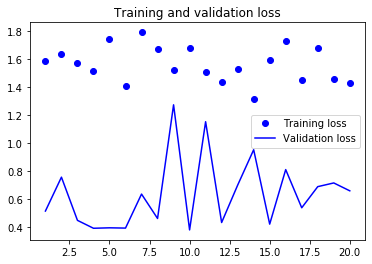

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

# acc = history.history['acc']
# val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [36]:
pred = model.predict(test_features)
pred

array([[22.90557  ],
       [14.553358 ],
       [20.961515 ],
       [29.105782 ],
       [13.36991  ],
       [14.622567 ],
       [32.398743 ],
       [14.86243  ],
       [14.878482 ],
       [14.738715 ],
       [33.069874 ],
       [16.517498 ],
       [14.633344 ],
       [23.48248  ],
       [28.033438 ],
       [10.868264 ],
       [14.438588 ],
       [ 8.946046 ],
       [29.16953  ],
       [14.274741 ],
       [13.143847 ],
       [25.087162 ],
       [13.414835 ],
       [23.515106 ],
       [22.187988 ],
       [16.251276 ],
       [36.05144  ],
       [14.906457 ],
       [27.406075 ],
       [29.51313  ],
       [14.495572 ],
       [13.781276 ],
       [23.28255  ],
       [14.145233 ],
       [16.654295 ],
       [28.10934  ],
       [17.030207 ],
       [16.411877 ],
       [13.733358 ],
       [16.587059 ],
       [23.500586 ],
       [28.951965 ],
       [14.589109 ],
       [14.17427  ],
       [16.001726 ],
       [14.954951 ],
       [34.4818   ],
       [37.13

In [37]:
pred_int = pred.astype('int')
testdf['Total rebars'] = pred_int
testdf.head()

,Pic Name,Total rebars
0,test_Depth_9280.png,22
1,20191024_10852_Depth_112034.png,14
2,test_Depth_14496.png,20
3,20190531_105600_Depth_5472.png,29
4,20190531_100725_Depth_20817.png,13


In [38]:
testdf.to_csv("./Result/yoresult24.csv", index=False, encoding='utf-8')
# testdf.to_csv("drive/My Drive/Colab Notebooks/Final Project/Task 1/Result/result18.csv", index=False, encoding='utf-8')

In [ ]:
model.save('task1_1220.h5')